In [1]:
import json 
import warnings
import os 
import openai
import os
import time
from tqdm import tqdm
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
from copy import copy
from transformers.trainer_utils import get_last_checkpoint
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib as mpl
from scipy import stats
import matplotlib as mpl
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


project_dir = os.path.abspath(
    os.path.join(os.path.abspath(os.getcwd()), "../"))

if project_dir not in sys.path:
    sys.path.append(project_dir)

from src.ranker.codex.models import CodexBasedModel
from src.ranker.codex.data import CrossDataSetForCodex
from src.ranker.ranker import Ranker as Ranker_new

warnings.filterwarnings("ignore")

In [2]:
problem_base_dir = "in_scope"

In [3]:
def get_embedding(
    text, 
    codex_model, 
):
    sleep_time = .1
    while True:
        try:
            emb = openai.Embedding.create(
                input=[text], model=codex_model
            )['data'][0]['embedding']
            return emb
        except Exception as e:
            if 'Please reduce' in str(e):
                text = text[:int(.9 * len(text))]
            time.sleep(sleep_time)


openai.api_key = os.getenv("OPENAI_API_KEY")
assert openai.api_key is not None

fold_to_problem_ids = {}
problem_id_to_fold = {}
with open(f"ranker_data/problem_id_to_fold.json") as f:
    data = json.load(f)
    problem_id_to_fold = data
    for k in data:
        v = data[k]
        if v not in fold_to_problem_ids:
            fold_to_problem_ids[v] = []
        fold_to_problem_ids[v].append(k)
        


In [4]:
def tokenize(text):
        tokens = nltk.word_tokenize(text)
        new_tokens = []
        for t in tokens:
            new_tokens.extend(nltk.wordpunct_tokenize(t))
        return " ".join(new_tokens)

def similarity_based_ranking(_data):
    ranks = []
    z3_calls = []
    for di in range(len(_data)):
        d = _data[di]
        z3, inv_count = 0, 0
        all_codes = [d['problem']] + [i['code'] for i in d['invariants']]
        all_codes = [tokenize(c) for c in all_codes]
        vectorizer = TfidfVectorizer()
        vectors = vectorizer.fit_transform(all_codes)
        vectors = vectors.toarray()
        problem_vector = vectors[0]
        inv_vectors = vectors[1:]
        similarities = []
        for i in inv_vectors:
            similarities.append(np.dot(i, problem_vector))
        sorted_indices = np.argsort(similarities)[::-1]
        reranked_invariants = [
            d['invariants'][i] for i in sorted_indices
        ]
        for i in reranked_invariants:
            z3 += i['call_to_z3']
            inv_count += 1
            if i['verified']:
                break
        z3_calls.append(z3)
        ranks.append(inv_count)
    return (ranks, z3_calls)

def randomly_rank_invariants(data, num_random_rankings):
    ranks = []
    z3_calls = []
    for d in data:
        pranks = []
        z3s = []
        for _ in range(num_random_rankings):
            z3 = 0
            invariants = copy(d['invariants'])
            np.random.shuffle(invariants)
            for iidx, i in enumerate(invariants):
                z3 += i['call_to_z3']
                if i['verified']:
                    pranks.append(iidx + 1)
                    break
            z3s.append(z3)
        z3_calls.append(np.mean(z3s).item())
        ranks.append(np.mean(pranks).item())
    return ranks, z3_calls

In [5]:
def generate_results(exp_name, codex_model):
    if codex_model == 'text-embedding-ada-002':
        model_shorthand = 'ada_002'
    elif codex_model == 'davinci-similarity':
        model_shorthand = 'davinci'
    exp_dir = f"llm-genrated-solutions/{exp_name}/details"
    files = [f for f in os.listdir(exp_dir) if f.endswith(".json")]
    
    problem_dir = f"problems/{problem_base_dir}"
    fold_data_path = f"results/details/{exp_name}-data.json"
    if os.path.exists(fold_data_path):
        data = json.load(open(fold_data_path))
        data_for_ranker = data['data_for_ranker']
        solved_data = data['solved_data']
        fold_data = data['fold_data']
    else:
        data_for_ranker = []
        solved_data = []
        fold_data = {
            "fold_0": [], "fold_1": [], "fold_2": [], "fold_3": [], "fold_4": [],
        }
        for f in files:
            d = json.load(open(f"{exp_dir}/{f}"))
            problem_name = d['problem']
            problem_path = f"{problem_dir}/{problem_name}.sl"
            problem = open(problem_path, "r").read()
            invariants = d['generated_invariants']
            data = {
                "problem_path": problem_path,
                "problem_name": problem_name,
                "problem": problem,
                "verified": d['verified'],
                "invariants": [
                    {
                        "code": i['inv'],
                        "verified": i['verified'],
                        'call_to_z3': i['feedback']['call_to_z3'],
                        'duration': i['duration'],
                    } for i in invariants
                ]
            }
            data_for_ranker.append(data)
            if d['verified']:
                solved_data.append(data)
                assert any([i['verified'] for i in invariants])
                if problem_name in problem_id_to_fold:
                    fold = problem_id_to_fold[problem_name]
                    fold_data[fold].append(data)
                else:
                    for fold in ["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"]:
                        fold_data[fold].append(data)
    # print(len(data_for_ranker), len(solved_data), len(fold_data))
    os.makedirs("results/details", exist_ok=True)
    def print_results(df, model):
        df.to_csv(f"results/details/{model}-{exp_name}-results.csv")
    if not os.path.exists(fold_data_path):
        with open(fold_data_path, "w") as f:
            json.dump({
                "data_for_ranker": data_for_ranker,
                "solved_data": solved_data,
                "fold_data": fold_data,
            }, f, indent=4)
    emb_file_name = f"llm-genrated-solutions/{exp_name}_embeddings_{model_shorthand}.json"
    cached_embeddings = dict()
    code_set = set()
    for f in fold_data:
        for d in fold_data[f]:
            code_set.add(d['problem'])
            for i in d['invariants']:
                code_set.add(i['code'])
    force_recompute = False
    if force_recompute or not os.path.exists(emb_file_name):
        for code in code_set:
            if code not in cached_embeddings:
                embedding = get_embedding(code, codex_model)
                cached_embeddings[code] = embedding
        with open(emb_file_name, "w") as f:
            json.dump(cached_embeddings, f)
            f.close()
    else:
        cached_embeddings = json.load(open(emb_file_name, "r"))

    not_found_codes = [
        code for code in code_set if code not in cached_embeddings
    ]
    assert len(not_found_codes) == 0 
    hidden_dim = CrossDataSetForCodex.get_dimension(codex_model)
    model = CodexBasedModel(hidden_dim=hidden_dim,model_name=codex_model,alpha=0)
    model_specific_arguments_for_ranker = {
        "model_name": codex_model, "no_train_rank": False,
    }
    bar = tqdm(['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4'])
    def rank_invariants(
        fold, _data, model, cached_embeddings,
        which='random', model_name_addon="",
        model_path=None, num_random_rankings=100,
    ):
        bar.set_description(f"{exp_name} {model_shorthand} Ranking {fold} problems with {which}")
        if which == 'gpt':
            ranks = []
            z3_calls = []
            for di in range(len(_data)):
                d = _data[di]
                z3, inv_count = 0, 0
                for ii in range(len(d['invariants'])):
                    i = d['invariants'][ii]
                    z3 += i['call_to_z3']
                    inv_count += 1
                    if i['verified']:
                        break
                z3_calls.append(z3)
                ranks.append(inv_count)
            return (ranks, z3_calls)
        elif which == 'similarity':
            return similarity_based_ranking(_data)
        elif which == 'random':
            return randomly_rank_invariants(_data, num_random_rankings)
        else:
            model_specific_arguments_for_ranker["cached_embeddings"] = cached_embeddings
            model_specific_arguments_for_ranker['no_train_rank'] = (which == 'untrained')
            new_data = []
            for d in _data:
                new_data.append({
                    'problem_path': d['problem_path'],
                    'problem': d['problem'],
                    'invariants': [
                        {
                            'code': i['code'],
                            'verified': i['verified'],
                            'call_to_z3': i['call_to_z3'],
                        } for i in d['invariants'] if isinstance(i, dict)
                    ]
                })
            if which == 'trained':
                if model_path is None:
                    ckpt = f"{project_dir}/models/ranker_result/{model_shorthand}{model_name_addon}" +\
                    f"/mp-2_mn-2_alpha-1/{fold}/checkpoint-best-avg_v_at_1"
                else:
                    ckpt = model_path
                model.load_state_dict(torch.load(open(f"{ckpt}/pytorch_model.bin", 'rb')))
            model.eval()
            torch.no_grad()
            ranker = Ranker_new(
                data_class=CrossDataSetForCodex, model_class=type(model),
                additional_comp_for_ranker=model_specific_arguments_for_ranker,
            )
            model.cuda()
            rank_function = ranker.rank_invariants
            ranked_data = rank_function(model, new_data, cached_embeddings, bar_tqdm=None)
            ranks = []
            z3_calls = []
            for d in ranked_data:
                z3 = 0
                ranked_invariants = d['invariants']
                for iidx, i in enumerate(ranked_invariants):
                    z3 += i['call_to_z3']
                    if i['verified']:
                        ranks.append(iidx + 1)
                        break
                z3_calls.append(z3)
            return ranks, z3_calls

    result_data = {'fold': [], 'experiment': [], 'ranks': [], 'z3_calls': []}
    for fold in bar:
        fold_1_data = fold_data[fold]
        gpt_ranks, gpt_z3_calls = rank_invariants(
            fold=fold, _data=copy(fold_1_data), model=None, 
            cached_embeddings=cached_embeddings, which='gpt'
        )
        result_data['fold'].extend([fold] * len(gpt_ranks))
        result_data['experiment'].extend(['gpt'] * len(gpt_ranks))
        result_data['ranks'].extend(gpt_ranks)
        result_data['z3_calls'].extend(gpt_z3_calls)

        random_ranks, random_z3_calls = rank_invariants(fold=fold,
            _data=copy(fold_1_data), model=None, 
            cached_embeddings=cached_embeddings, which='random'
        )
        result_data['fold'].extend([fold] * len(random_ranks))
        result_data['experiment'].extend(['random'] * len(random_ranks))
        result_data['ranks'].extend(random_ranks)
        result_data['z3_calls'].extend(random_z3_calls)

        sim_ranks, sim_z3_calls = rank_invariants(fold=fold,
            _data=copy(fold_1_data), model=None, 
            cached_embeddings=cached_embeddings, which='similarity'
        )
        result_data['fold'].extend([fold] * len(sim_ranks))
        result_data['experiment'].extend(['TF-IDF'] * len(sim_ranks))
        result_data['ranks'].extend(sim_ranks)
        result_data['z3_calls'].extend(sim_z3_calls)

        untrained_ranks, untrained_z3 = rank_invariants(fold=fold,
            _data=copy(fold_1_data), model=model, 
            cached_embeddings=cached_embeddings, which='untrained'
        )
        result_data['fold'].extend([fold] * len(untrained_ranks))
        result_data['experiment'].extend(['davinci embeddings'] * len(untrained_ranks))
        result_data['ranks'].extend(untrained_ranks)
        result_data['z3_calls'].extend(untrained_z3)
        
        model_path = get_last_checkpoint(
            f"{project_dir}/models/ranker_result/{model_shorthand}/mp-2_mn-2_alpha-0/" +\
            f"{fold}/") # checkpoint-best-avg_v_at_1"
        ranker_alpha_0, alpha_z3 = rank_invariants(fold=fold,
            _data=copy(fold_1_data), model=model, 
            cached_embeddings=cached_embeddings, which='trained',
            model_name_addon="",
            model_path=model_path
        )
        result_data['fold'].extend([fold] * len(ranker_alpha_0))
        result_data['experiment'].extend(['ranked'] * len(ranker_alpha_0))
        result_data['ranks'].extend(ranker_alpha_0)
        result_data['z3_calls'].extend(alpha_z3)

        df = pd.DataFrame(result_data)
        print_results(df, model=f"{codex_model}-{fold}")

In [6]:
for exp_name in ["gpt-4", "gpt-3.5"]:
    for codex_model in ["text-embedding-ada-002", "davinci-similarity"]:
        generate_results(exp_name, codex_model)

gpt-4 ada_002 Ranking fold_4 problems with trained: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]   
gpt-4 davinci Ranking fold_4 problems with trained: 100%|██████████| 5/5 [01:47<00:00, 21.57s/it]   
gpt-3.5 ada_002 Ranking fold_4 problems with trained: 100%|██████████| 5/5 [00:40<00:00,  8.09s/it]   
gpt-3.5 davinci Ranking fold_4 problems with trained: 100%|██████████| 5/5 [04:27<00:00, 53.41s/it]   


['LLM Ranks' 'Expected Ranks' 'TF-IDF' 'Davinci emb.' 'Ada emb.'
 'iRank-Ada' 'iRank-Davinci']
================== Ranks ===================
       Experiment       mean  median
0        Ada emb.  115.89200   31.50
1    Davinci emb.  120.02000   32.00
2  Expected Ranks   95.16756   30.67
3       LLM Ranks  189.78400   62.00
4          TF-IDF  103.45200   24.00
5       iRank-Ada   38.78400    5.00
6   iRank-Davinci   34.48400    5.00
                     # Verified
experiment     rank            
Ada emb.       1           11.2
               2           14.8
               5           21.6
               10          30.0
Davinci emb.   1           10.4
               2           14.4
               5           20.8
               10          33.6
Expected Ranks 1            9.2
               2           11.2
               5           19.2
               10          26.0
LLM Ranks      1            5.2
               2            7.6
               5           11.6
               10   

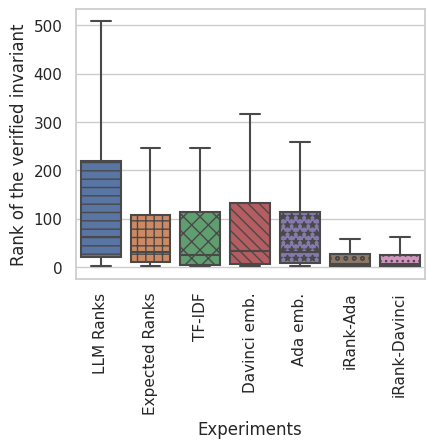

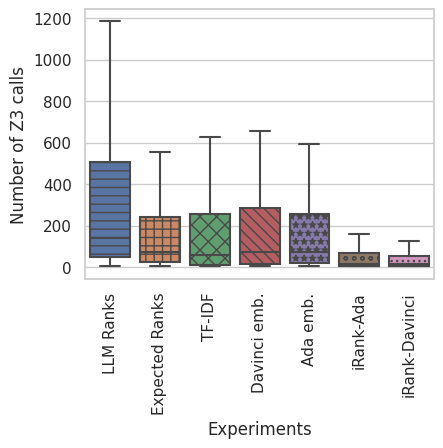

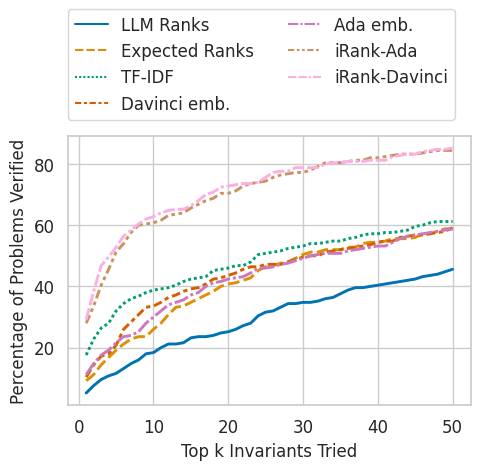

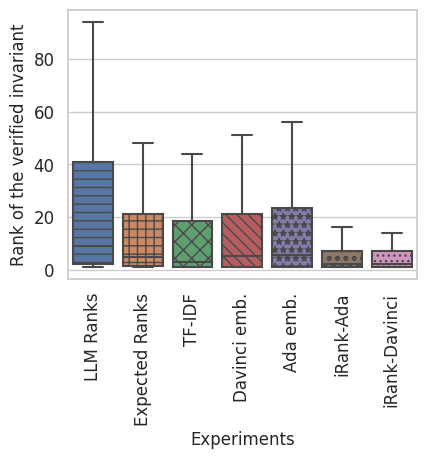

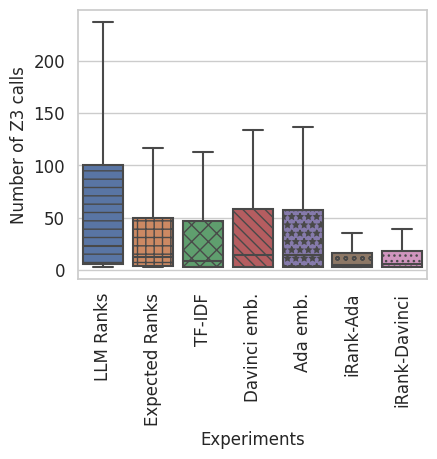

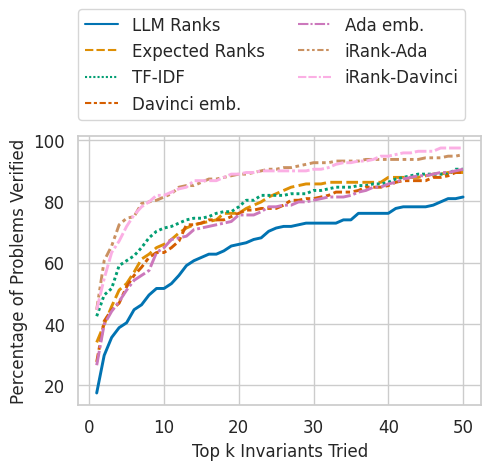

In [7]:
import seaborn as sns
sns.set_theme(style="whitegrid")
    
def draw_graphs(
        exp_name, total, save_file_name, 
        folder, input_folder="aggregated_results", 
):
    os.makedirs(folder, exist_ok=True)
    df1 = pd.read_csv(
        f"./{input_folder}/davinci-similarity-fold_4" +\
            f"-{exp_name}-results.csv", index_col=0
    )
    df2 = pd.read_csv(
        f"./{input_folder}/text-embedding-ada-002-fold_4" +\
            f"-{exp_name}-results.csv", index_col=0
    )
    gpt_result = df1[df1.experiment == "gpt"]
    gpt_result.experiment = "LLM Ranks"
    random_result = df2[df2.experiment == "random"]
    random_result.experiment = "Expected Ranks"
    davinci_result = df1[df1.experiment == "davinci embeddings"]
    davinci_result.experiment = "Davinci emb."
    ada_result = df2[df2.experiment == "davinci embeddings"]
    ada_result.experiment = "Ada emb."
    ranker_result = df1[df1.experiment == "ranked"]
    ranker_result.experiment = "iRank-Davinci"
    ranker_result_ada = df2[df2.experiment == "ranked"]
    ranker_result_ada.experiment = "iRank-Ada"
    tf_idf_result = df2[df2.experiment == "TF-IDF"]
    df = pd.concat(
        [gpt_result, random_result, tf_idf_result,
        davinci_result, ada_result, 
        ranker_result_ada, ranker_result]
    )
    df['z3_calls'] = df['z3_calls'].astype(int) - 1
    print(df['experiment'].unique())
    d = df.copy()
    del d['fold']
    del d['z3_calls']
    grouped_df = d.groupby('experiment')
    mean = grouped_df.mean()
    mean = mean.rename(columns={'ranks': 'mean'})
    median = grouped_df.median()
    median = median.rename(columns={'ranks': 'median'})
    x = pd.concat([mean, median], axis=1)
    x = x.reset_index()
    x = x.rename(columns={'experiment': 'Experiment'})
    print("================== Ranks ===================")
    print(x)
    hatches = ['--', '++', 'xx', '\\\\\\', '**', 'oo', '...', "///"]
    #  Ranks
    plt.figure(figsize=(4.5, 3.5))
    ax = sns.boxplot(y="ranks", x='experiment', data=df,showfliers=False,)
    patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    for patch, hatch in zip(patches, hatches):
        patch.set_hatch(hatch)
    plt.xlabel("Experiments")
    plt.ylabel("Rank of the verified invariant")
    plt.xticks(rotation=90)
    plt.savefig(f"{folder}/{save_file_name}-ranks.pdf", bbox_inches='tight')
    # Z3 calls
    plt.figure(figsize=(4.5, 3.5))
    ax = sns.boxplot(y="z3_calls", x='experiment', data=df, showfliers=False,)
    patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    for patch, hatch in zip(patches, hatches):
        patch.set_hatch(hatch)
    plt.xlabel("Experiments")
    plt.ylabel("Number of Z3 calls")
    plt.xticks(rotation=90)
    plt.savefig(f"{folder}/{save_file_name}-z3_calls.pdf", bbox_inches='tight')
    results = {}
    data = df.to_dict('records')
    max_ranks = 50
    for d in data:
        exp = d['experiment']
        rank = int(d['ranks'])
        if d['experiment'] not in results:
            results[exp] = {k: 0 for k in range(1, max_ranks + 1)}
        for k in range(rank, max_ranks + 1):
            results[exp][k] += 1   
    result_df = {"experiment": [], "rank": [], "# Verified": []} 
    for exp in results:
        for rank in results[exp]:
            result_df["experiment"].append(exp)
            result_df["rank"].append(int(rank))
            result_df["# Verified"].append(float(results[exp][rank]) * 100 / total)
    result_df = pd.DataFrame(result_df)
    plt.figure(figsize=(5.2, 3.5))
    # Increase the font size for the legend text and axes labels
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['font.size'] = 12
    sns.lineplot(
        data=result_df, x="rank", y="# Verified",
        hue="experiment", palette="colorblind",
        style="experiment", 
        dashes=True,
        linewidth=2.1,
    )
    plt.ylabel("Percentage of Problems Verified")
    plt.xlabel("Top k Invariants Tried")
    plt.legend(ncol=2, loc='upper center', 
               bbox_to_anchor=(0.48, 1.5))
    plt.savefig(f"{folder}/{save_file_name}-lineplot.pdf", bbox_inches='tight')
    print("=====================================")
    vdf_1 = result_df[result_df["rank"] == 1]
    vdf_2 = result_df[result_df["rank"] == 2]
    vdf_5 = result_df[result_df["rank"] == 5]
    vdf_10 = result_df[result_df["rank"] == 10]
    complete = pd.concat([vdf_1, vdf_2, vdf_5, vdf_10], axis=0).reset_index(drop=True)
    print(complete.groupby(["experiment", "rank"]).mean())
    print("=====================================")


    
draw_graphs(
    exp_name="gpt-3.5",
    total=250,
    save_file_name="gpt3.5",
    folder="results/graphs",
    input_folder="results/details",
)

draw_graphs(
    exp_name="gpt-4",
    total=188,
    save_file_name="gpt4",
    folder="results/graphs",
    input_folder="results/details",
)
